## A.3: Final Report: SOTU

### Load Libraries

In [39]:
import os
os.getcwd()

'/Users/ksenialuu/personal/NU_453_NLP'

In [40]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# import nltk.download
# from nltk.download import stopwords

import nltk
#nltk.download('stopwords',download_dir='/Users/ksenialuu/personal/NU_453_NLP/nltk_data') # only needed to download these once
#nltk.download('wordnet',download_dir='/Users/ksenialuu/personal/NU_453_NLP/nltk_data')
nltk.data.path.append('https://github.com/ksenluu/NU_453_NLP/tree/master/nltk_data')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

In [41]:
# Functionality to turn stemming on or off
STEMMING = False
NGRAM_LENGTH = 2

#### Pandas Parameters

In [42]:
#pandas parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [43]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Function to process documents

In [44]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    new_stopwords = ['years','great','tonight','congress','freedom','united','states','united states','americans','america','american','americas','government','people','world','shall','would','nations','national','nation'] #remove repeating terms
    stop_words = stop_words.union(new_stopwords)
    #stop_words = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/english")
    tokens = [w for w in tokens if not w in stop_words]        
    # word stemming    
    #if STEMMING:
        #ps=PorterStemmer()
        #tokens=[ps.stem(word) for word in tokens]
    # Lemmatization to account for things like plurals
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token) for token in tokens]
    
    return tokens

###   Functions to label encoding

In [6]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [7]:
# read data
data = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/sotu_corpus_small.csv")


In [8]:
# new data frame with split value columns 
new = data["DSI_Title"].str.split("_", n = 1, expand = True) 
  
# making separate President_Name column from new data frame 
data["President_Name"] = new[0] 
  
# making separate Year_SOTU column from new data frame 
data["Year_SOTU"] = new[1] 
  
new = data["Year_SOTU"].str.split(".", n = 1, expand = True) 
data["Year_SOTU"] = new[0] 

# df display 
data.shape
data.head(5) 

(102, 5)

Unnamed: 0         DSI_Title                                               Text President_Name Year_SOTU
0           0   Reagan_1982.txt  Mr. Speaker, Mr. President, distinguished Memb...         Reagan      1982
1           1   Wilson_1914.txt  GENTLEMEN OF THE CONGRESS:  The session upon w...         Wilson      1914
2           2  Madison_1814.txt  Fellow-Citizens of the Senate and House of Rep...        Madison      1814
3           3  Johnson_1969.txt  Mr. Speaker, Mr. President, Members of the Con...        Johnson      1969
4           4   Hoover_1930.txt  To the Senate and House of Representatives:  I...         Hoover      1930

### Processing text into lists

In [9]:
# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.

# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

### Sklearn TFIDF 
note the ngram_range will allow you to include multiple words within the TFIDF matrix

In [10]:
# Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3), min_df=0.1, max_df=0.80)#, max_features=50000)

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [11]:
# Verify TFIDF_Matrix has been created.
matrix.shape
matrix.head()

(102, 2305)

abandon  abandoned  ability     about     above   abroad  absolutely  abundance  abundant     abuse    accept  accepted  access  accommodation  accomplish  accomplished  accomplishment    accord  according  accordingly   account   achieve  achieved  achievement  achieving  acquired    across     acted    acting    action    active  activity    actual  actually   adapted     added    adding  addition  additional   address  addressed  adequate  adjusted  adjustment  administration  administrative  admit     adopt   adopted  adoption   advance  advanced  advancement  advancing  advantage  adversary    advice  advisable    affair    affect  affected  affecting  afford  affordable  afforded  afghanistan   afraid  africa     after     again    agency    agenda  agent  aggression  aggressive     agree    agreed  agreement  agricultural  agriculture     ahead     alike  alliance  allied    allow   allowed  allowing     ally    almost     alone    along   already  \
Reagan_1982.txt       0.0        0.0      0.0  0.060915  0.011221  0.00000         0.0   0.000000  0.000000  0.013285  0.000000  0.000000     0.0       0.016093         0.0      0.000000             0.0  0.000000   0.000000          0.0  0.000000  0.011936  0.000000     0.000000   0.018612       0.0  0.000000  0.018612  0.000000  0.007706  0.000000  0.011936  0.000000  0.016093  0.000000  0.000000  0.000000  0.000000    0.000000  0.064596        0.0  0.000000       0.0    0.000000        0.082730        0.000000    0.0  0.000000  0.000000       0.0  0.000000       0.0          0.0        0.0   0.000000   0.017051  0.000000   0.000000  0.000000  0.000000  0.000000   0.017051     0.0         0.0       0.0     0.017783  0.00000     0.0  0.038148  0.065473  0.000000  0.016715    0.0    0.011640    0.000000  0.000000  0.000000   0.000000      0.000000     0.000000  0.044351  0.015528  0.015528     0.0  0.00000  0.000000       0.0  0.01164  0.022995  0.000000  0.01164  0.057288   
Wilson_1914.txt       0.0        0.0      0.0  0.012911  0.016649  0.00000         0.0   0.025298  0.025298  0.000000  0.000000  0.049599     0.0       0.000000         0.0      0.000000             0.0  0.000000   0.000000          0.0  0.017937  0.000000  0.000000     0.038336   0.000000       0.0  0.000000  0.027615  0.025298  0.057166  0.000000  0.017710  0.000000  0.047754  0.000000  0.000000  0.055229  0.000000    0.000000  0.038336        0.0  0.075008       0.0    0.000000        0.000000        0.000000    0.0  0.021908  0.000000       0.0  0.015698       0.0          0.0        0.0   0.000000   0.000000  0.000000   0.000000  0.000000  0.023038  0.000000   0.000000     0.0         0.0       0.0     0.000000  0.00000     0.0  0.022640  0.012143  0.000000  0.000000    0.0    0.017271    0.000000  0.044540  0.023877   0.000000      0.000000     0.000000  0.000000  0.000000  0.000000     0.0  0.02227  0.023038       0.0  0.00000  0.034117  0.000000  0.00000  0.024285   
Madison_1814.txt      0.0        0.0      0.0  0.000000  0.025483  0.00000         0.0   0.000000  0.000000  0.030170  0.031052  0.000000     0.0       0.000000         0.0      0.000000             0.0  0.000000   0.036547          0.0  0.000000  0.000000  0.000000     0.029339   0.000000       0.0  0.000000  0.000000  0.000000  0.017500  0.035263  0.000000  0.000000  0.000000  0.040384  0.061208  0.000000  0.000000    0.000000  0.000000        0.0  0.000000       0.0    0.000000        0.000000        0.000000    0.0  0.000000  0.033001       0.0  0.000000       0.0          0.0        0.0   0.045416   0.038722  0.000000   0.000000  0.023485  0.000000  0.000000   0.000000     0.0         0.0       0.0     0.000000  0.00000     0.0  0.017327  0.000000  0.000000  0.000000    0.0    0.026435    0.000000  0.000000  0.000000   0.000000      0.000000     0.000000  0.000000  0.000000  0.000000     0.0  0.00000  0.000000       0.0  0.00000  0.000000  0.021046  0.00000  0.037172   
Johnson_1969.txt      0.0        0.0      0.0  0.118192  0

In [12]:
# Get unique names of President_Name to ensure BushW and BusHW were enetered correctly.
data['President_Name'].unique()

array(['Reagan', 'Wilson', 'Madison', 'Johnson', 'Hoover', 'Roosevelt',
       'Truman', 'Kennedy', 'Jefferson', 'Monroe', 'Trump', 'Eisenhower',
       'Obama', 'Adams', 'BushHW', 'Cleveland', 'Grant', 'Washington',
       'Ford', 'BushW', 'Nixon', 'Carter', 'Arthur'], dtype=object)

(<Figure size 1368x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a278cccd0>)

Text(0.5, 0, 'President Name')

Text(0, 0.5, 'Count of SOTU')

Text(0.5, 1.0, 'US: State of the Union Speeches (SOTU)')

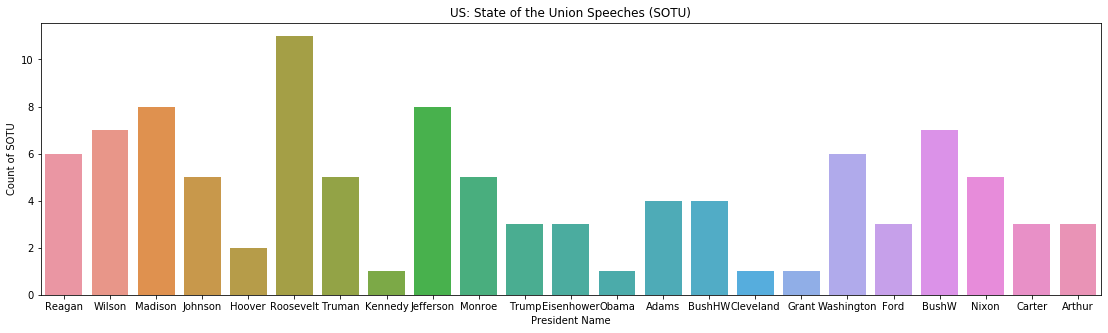

In [13]:
# Simple plot to show the number of SOTU speeches by President Name

import seaborn as sns

plt.subplots(figsize=(19,5))
ax = sns.countplot(x="President_Name", data=data)
# plt.savefig("plot-president_name.pdf", bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, pad_inches=0.25)
plt.xlabel('President Name')
plt.ylabel('Count of SOTU')
plt.title('US: State of the Union Speeches (SOTU)')
plt.show()

### Explore TFIDF Values

In [14]:
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

In [15]:
outlier_list.shape

(139, 1)

### Doc2Vec

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

### Gensim Word2vec 
Note, there are opportunities to use the word2vec matrix to determine words which are similar.  Similar words can be used to create equivalent classes.  
k-means is not used to group individual words using the Word2Vec output.

In [ ]:
#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

### K Means Clustering - TFIDF
the following section runs applies the k-means algorithm on the TFIDF matrix.

In [16]:
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])


print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=89, tol=0.0001, verbose=0)

Top terms per cluster:
Cluster 0:


(None,)

 shall
 matter
 world
 railway
 action
 thought
 railroad
 counsel
 german
 ought
 legislation
 impossible
 because
 business
 commission
Cluster 0 titles: Wilson_1914.txt, Wilson_1917.txt, Wilson_1916.txt, Wilson_1913.txt, Wilson_1918.txt,Cluster 1:


(None,)

 america
 program
 world
 federal
 american
 president
 tonight
 billion
 budget
 vietnam
 energy
 propose
 today
 spending
 percent
Cluster 1 titles: Reagan_1982.txt, Johnson_1969.txt, Johnson_1968.txt, Ford_1976.txt, Ford_1977.txt, Ford_1975.txt, Nixon_1972.txt, Nixon_1973.txt, Nixon_1971.txt, Nixon_1970.txt, Johnson_1966.txt, Nixon_1974.txt, Johnson_1965.txt, BushW_2001.txt,Cluster 2:


(None,)

 treaty
 subject
 british
 commerce
 vessel
 shall
 provision
 spain
 indian
 object
 consideration
 militia
 measure
 treasury
 between
Cluster 2 titles: Madison_1814.txt, Madison_1815.txt, Madison_1816.txt, Madison_1812.txt, Madison_1813.txt, Madison_1811.txt, Jefferson_1808.txt, Madison_1810.txt, Monroe_1820.txt, Adams_1799.txt, Adams_1798.txt, Monroe_1822.txt, Monroe_1819.txt, Cleveland_1887.txt, Grant_1872.txt, Monroe_1818.txt, Washington_1791.txt, Adams_1800.txt, Washington_1793.txt, Washington_1792.txt, Monroe_1817.txt, Washington_1796.txt, Washington_1795.txt, Adams_1797.txt, Washington_1794.txt, Madison_1809.txt, Jefferson_1805.txt, Jefferson_1804.txt, Jefferson_1806.txt, Jefferson_1807.txt, Arthur_1883.txt, Jefferson_1803.txt, Jefferson_1802.txt, Arthur_1882.txt, Jefferson_1801.txt, Arthur_1881.txt,Cluster 3:


(None,)

 america
 terrorist
 tonight
 american
 world
 child
 terror
 regime
 worker
 freedom
 woman
 health
 economy
 weapon
 reform
Cluster 3 titles: Trump_2017.txt, Obama_2016.txt, Trump_2019.txt, Trump_2018.txt, BushW_2005.txt, BushW_2004.txt, BushW_2006.txt, BushW_2007.txt, BushW_2003.txt, BushW_2002.txt,Cluster 4:


(None,)

 world
 economic
 program
 shall
 today
 production
 freedom
 federal
 problem
 democracy
 cannot
 effort
 defense
 price
 action
Cluster 4 titles: Hoover_1930.txt, Hoover_1932.txt, Roosevelt_1938.txt, Truman_1949.txt, Truman_1948.txt, Roosevelt_1939.txt, Kennedy_1963.txt, Eisenhower_1959.txt, Eisenhower_1958.txt, Roosevelt_1940.txt, Roosevelt_1941.txt, Roosevelt_1943.txt, Roosevelt_1942.txt, Roosevelt_1944.txt, Eisenhower_1957.txt, Roosevelt_1937.txt, Truman_1952.txt, Wilson_1920.txt, Roosevelt_1936.txt, Roosevelt_1934.txt, Truman_1951.txt, Truman_1950.txt, Roosevelt_1935.txt, Johnson_1964.txt, Wilson_1919.txt,Cluster 5:


(None,)

 america
 world
 tonight
 soviet
 budget
 freedom
 family
 child
 american
 economic
 federal
 growth
 program
 nuclear
 spending
Cluster 5 titles: Reagan_1984.txt, Reagan_1985.txt, Reagan_1987.txt, Reagan_1986.txt, BushHW_1992.txt, BushHW_1991.txt, BushHW_1990.txt, BushHW_1989.txt, Reagan_1988.txt, Carter_1980.txt, Carter_1978.txt, Carter_1979.txt,

### Plotting 
Convert two components as we're plotting points in a two-dimensional plane
"precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

In [ ]:
%matplotlib inline


In [ ]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [ ]:
fig.savefig('Images/clusters.png')

### Review Clusters

In [ ]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()

In [ ]:
# look at frequent terms across clusters
term_clusters

In [ ]:
titles = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
titles = titles.stack() #stack document names into 1 column
titles = titles.reset_index() #move index into a column
titles = titles.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
titles = titles.drop(['level_1'], axis=1) #drop unecessary column
titles.head()

In [ ]:
# join TFIDF values to documents in new dataframe w/ clusters
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = titles.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

In [ ]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [ ]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

In [ ]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(5,30))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

In [ ]:
p.get_figure().savefig('Images/heatmap_6.png')

# heatmap_1 using 8 clusters, no additional stopwords removed
# heatmap_2 using 8 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_3 using 6 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_4 using 6 clusters, reduced term size to 1-3 words, removed frequent words
# heatmap_5 using 6 clusters, reduced term size to 1-2 words, removed frequent words, increased top term size to 15 *BEST*
# heatmap_6 using 6 clsuters, reduced term size to 1-2 words, removed frequent words, increased top term size to 20

##### Look at terms that show up in all documents

In [ ]:
matrix_copy = matrix.copy() #copy dataframe
matrix_copy = matrix_copy.T  #transpose

matrix_copy[(matrix_copy != 0).all(1)] # pull terms that show up in all documents


### K Means Clustering Doc2Vec
The following section of code is to run the k-means algorithm on the doc2vec outputs.

Note the differences in document clusters compared to the TFIDF matrix.

In [ ]:
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

### Plotting Doc2vec
Convert two components as we're plotting points in a two-dimensional plane "precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

In [ ]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [ ]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
cv_matrix=cv.fit_transform(final_processed_text)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

### Classification using various RF Model

The following section is used to create a model to predict the clusters labels based on the the TFIDF matrix and the doc2vec vectors.  

Note the model performance using the two different vectorization methods.

In [ ]:
model_RF=RandomForestClassifier()

#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=5)

#mean CV score
np.mean(cv_score)

#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X, Y, cv=5)

#mean CV score
np.mean(cv_score)

In [ ]:
# Trying few things out (Ali)

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(10, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(10, 'tf_corpus'))